### Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import wandb
from torchvision.utils import make_grid

### Set Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

Device Used: cuda


### Data Loading and Processing

In [3]:
#Dataset for AFHQ
class AFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.class_mapping = {}
        
        extensions = (".jpg", ".jpeg", ".png")
        # go through all sub-directories
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            full_path = os.path.join(root_dir, category)
            if os.path.exists(full_path):
                self.class_mapping[label] = category
                for img_name in os.listdir(full_path):
                    if img_name.endswith(extensions):
                        self.image_paths.append(os.path.join(full_path, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [4]:
class AFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_mapping = {}
        
        extensions = (".jpg", ".jpeg", ".png")
        for label, category in enumerate(sorted(os.listdir(root_dir))):
            full_path = os.path.join(root_dir, category)
            if os.path.exists(full_path):
                self.class_mapping[label] = category
                for img_name in os.listdir(full_path):
                    if img_name.endswith(extensions):
                        self.image_paths.append(os.path.join(full_path, img_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [5]:
# Hyperparameters
img_size = 64
batch_size = 64

# dataset paths
train_dir = '/home/user/javeda1/stargan-v2/data/afhq/train'
val_dir = '/home/user/javeda1/stargan-v2/data/afhq/val'
# BATCH_SIZE = 64
# LATENT_DIM = 128
# LEARNING_RATE = 0.0001

### Define augmentations

In [6]:
transform = transforms.Compose([
    
        transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.Resize((img_size, img_size)), # image is downsampled here
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [7]:
# Load the train and val dataset
train_dataset = AFHQDataset(root_dir=train_dir, transform=transform)
val_dataset = AFHQDataset(root_dir=val_dir, transform=transform)

# DataLoaders for train and val sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

### Visualize Dataset

In [8]:
def show_random_images(dataloader, num_images=12):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    class_mapping = dataloader.dataset.class_mapping
    
    # creates a suitable grid
    # grid_size = int(np.ceil(np.sqrt(num_images)))
    num_rows = int(np.sqrt(num_images))
    num_cols = int(np.ceil(num_images / num_rows))
    # print(num_cols, num_rows)
    plt.figure(figsize=(6, 6))
    plt.suptitle("Sample images from AFHQ dataset")
    
    for idx in range(min(num_images, len(images))):
        plt.subplot(num_rows, num_cols, idx + 1)
        
        img = images[idx].permute(1, 2, 0).numpy()
        max_val = np.max(img)
        min_val = np.min(img)
        img = (img - min_val) / (max_val - min_val)
        
        plt.imshow(img)
        plt.title(f'Class: {class_mapping[labels[idx].item()]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

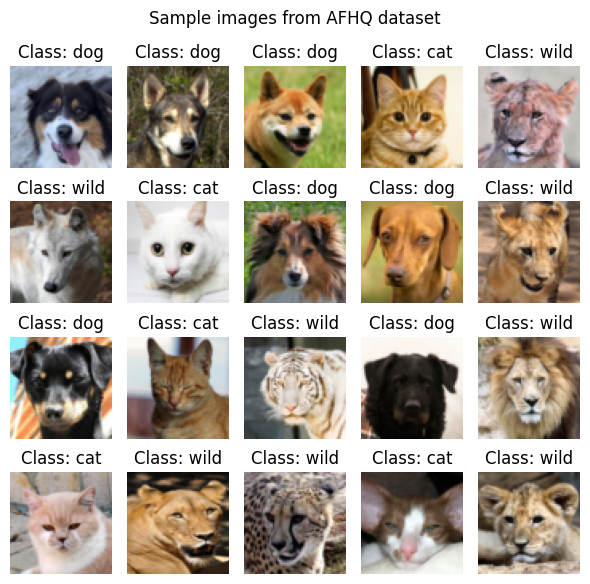

In [9]:
show_random_images(train_loader, num_images=20)

In [10]:
# def visualize_images(dataset, category_label, num_images=15, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
#     """
#     Visualizes the first `num_images` images for a given category label.
    
#     Args:
#         dataset (AFHQDataset): The dataset to visualize.
#         category_label (str): The category to filter for visualization.
#         num_images (int): Number of images to display.
#         mean (tuple): Mean used for normalization (if applied).
#         std (tuple): Std deviation used for normalization (if applied).
#     """
#     def denormalize(tensor, mean, std):
#         """Denormalizes a tensor image."""
#         mean = torch.tensor(mean).view(3, 1, 1)
#         std = torch.tensor(std).view(3, 1, 1)
#         return tensor * std + mean

#     images_shown = 0
#     plt.figure(figsize=(num_images * 2, 2))

#     for i in range(len(dataset)):
#         img = dataset[i]
#         img_path = dataset.image_paths[i]
#         # Check if the image belongs to the specified category
#         if category_label in img_path:
#             img = denormalize(img, mean, std)  # Denormalize the image
#             img = img.clamp(0, 1)  # Ensure values are in [0, 1]

#             plt.subplot(1, num_images, images_shown + 1)
#             plt.imshow(img.permute(1, 2, 0).numpy())
#             plt.axis("off")
#             plt.title(category_label, fontsize=8)
            
#             images_shown += 1
#             if images_shown >= num_images:
#                 break

#     plt.suptitle(f"Images for category: {category_label}", fontsize=16)
#     plt.show()

In [11]:
# # Visualize images from a specific category
# visualize_images(train_dataset, category_label="cat", num_images=10)


In [12]:
def vae_loss_function(recon_x, x, mu, log_var, kl_weight=1):
    """
    VAE loss: Reconstruction loss + KL divergence
    """
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
    return recon_loss + kl_divergence * kl_weight


def train_vae(model, train_loader, optimizer, kl_weight, device):
    """
    Train the VAE for one epoch.
    """
    model.train()
    running_loss = 0.0

    for inputs in train_loader:  # Labels are not needed for VAE
        inputs = inputs.to(device)
        optimizer.zero_grad()

        recon_x, mu, log_var = model(inputs)
        loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight=kl_weight)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader.dataset)
    return avg_loss


def evaluate_vae(model, eval_loader, kl_weight, device):
    """
    Evaluate the VAE after each epoch.
    """
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs in eval_loader:
            inputs = inputs.to(device)
            recon_x, mu, log_var = model(inputs)
            loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight=kl_weight)
            running_loss += loss.item()

    avg_loss = running_loss / len(eval_loader.dataset)
    return avg_loss


def run_vae_training(
    model, train_loader, eval_loader, device, num_epochs, learning_rate=0.001, project="vae-training", name="vae_run", kl_weight=0.1):
    """
    Train and evaluate the VAE with W&B logging.
    """
    wandb.init(project=project, name=name, config={"learning_rate": learning_rate, "num_epochs": num_epochs})
    config = wandb.config

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    eval_losses = []

    for epoch in tqdm(range(num_epochs)):
        train_loss = train_vae(model, train_loader, optimizer,kl_weight, device)
        eval_loss = evaluate_vae(model, eval_loader, kl_weight, device)

        train_losses.append(train_loss)
        eval_losses.append(eval_loss)

        # Log metrics to W&B
        wandb.log({"epoch": epoch + 1, "train_loss": train_loss, "eval_loss": eval_loss})

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Eval Loss: {eval_loss:.4f}")

    wandb.finish()
    return model, train_losses, eval_losses

In [13]:
def vae_loss_function(recon_x, x, mu, log_var, kl_weight=1):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence * kl_weight, recon_loss, kl_divergence

def train_vae(model, train_loader, optimizer, kl_weight, device):
    model.train()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    for inputs, _ in train_loader:  #labels not used
        inputs = inputs.to(device)
        optimizer.zero_grad()
        recon_x, mu, log_var = model(inputs)
        loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        
    dataset_size = len(train_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def evaluate_vae(model, val_loader, kl_weight, device):
    model.eval()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            recon_x, mu, log_var = model(inputs)
            loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
            
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()
            
    dataset_size = len(val_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def run_vae_training(
    model, train_loader, val_loader, device, num_epochs, learning_rate=0.001, 
    project="vae-training", name="vae_run", kl_weight=0.1, step_size=30, gamma=0.1):
    
    # Initialize W&B logging
    wandb.init(project=project, name=name, 
               config={
                   "learning_rate": learning_rate,
                   "num_epochs": num_epochs,
                   "step_size": step_size,
                   "gamma": gamma,
                   "kl_weight": kl_weight
               })
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_metrics = train_vae(model, train_loader, optimizer, kl_weight, device)
        # Evaluate after each epoch
        val_metrics = evaluate_vae(model, val_loader, kl_weight, device)
        
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()
        
        # Log to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train/total_loss": train_metrics['total_loss'],
            "train/recon_loss": train_metrics['recon_loss'],
            "train/kl_loss": train_metrics['kl_loss'],
            "val/total_loss": val_metrics['total_loss'],
            "val/recon_loss": val_metrics['recon_loss'],
            "val/kl_loss": val_metrics['kl_loss'],
            "learning_rate": current_lr
        })
        
        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Train - Total: {train_metrics['total_loss']:.4f}, "
              f"Recon: {train_metrics['recon_loss']:.4f}, "
              f"KL: {train_metrics['kl_loss']:.4f}")
        print(f"Eval  - Total: {val_metrics['total_loss']:.4f}, "
              f"Recon: {val_metrics['recon_loss']:.4f}, "
              f"KL: {val_metrics['kl_loss']:.4f}")
    
    # End W&B run
    wandb.finish()
    return model

In [14]:
def vae_loss_function(recon_x, x, mu, log_var, kl_weight=1):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_divergence * kl_weight, recon_loss, kl_divergence

# def vae_loss_function(recon_x, x, mu, log_var, kl_weight=1):
#     recon_loss = F.mse_loss(recon_x, x)
#     kl_divergence = (-0.5 * (1 + log_var - mu**2 - log_var.exp()).sum(dim=1)).mean(dim=0)
#     return recon_loss + kl_divergence * kl_weight, recon_loss, kl_divergence

def vae_loss_function(recon_x, x, mu, log_var, kl_weight=1):
    # Reconstruction loss with BCE
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL Divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return recon_loss + kl_divergence * kl_weight, recon_loss, kl_divergence
    
def train_vae(model, train_loader, optimizer, kl_weight, device):
    model.train()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    for inputs, _ in train_loader:  #labels not used
        inputs = inputs.to(device)
        optimizer.zero_grad()
        recon_x, mu, log_var = model(inputs)
        loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_recon_loss += recon_loss.item()
        running_kl_loss += kl_loss.item()
        
    dataset_size = len(train_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def evaluate_vae(model, val_loader, kl_weight, device):
    model.eval()
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            recon_x, mu, log_var = model(inputs)
            loss, recon_loss, kl_loss = vae_loss_function(recon_x, inputs, mu, log_var, kl_weight)
            
            running_loss += loss.item()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()
            
    dataset_size = len(val_loader.dataset)
    return {
        'total_loss': running_loss / dataset_size,
        'recon_loss': running_recon_loss / dataset_size,
        'kl_loss': running_kl_loss / dataset_size
    }

def run_vae_training(
    model, train_loader, val_loader, device, num_epochs, learning_rate=0.001, 
    project="vae-training", name="vae_run", kl_weight=0.1, step_size=30, gamma=0.1):
    
    # Sample a small batch for visualization (adjust batch_size as needed)
    inputs, _ = next(iter(train_loader))
    inputs = inputs.to(device)
    
    # Initialize W&B logging
    wandb.init(project=project, name=name, 
               config={
                   "learning_rate": learning_rate,
                   "num_epochs": num_epochs,
                   "step_size": step_size,
                   "gamma": gamma,
                   "kl_weight": kl_weight
               })
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    for epoch in tqdm(range(num_epochs)):
        # Train for one epoch
        train_metrics = train_vae(model, train_loader, optimizer, kl_weight, device)
        # Evaluate after each epoch
        val_metrics = evaluate_vae(model, val_loader, kl_weight, device)
        
        current_lr = scheduler.get_last_lr()[0]
        scheduler.step()

        # Log images to W&B
        with torch.no_grad():
            # # Sample a small batch for visualization (adjust batch_size as needed)
            # inputs, _ = next(iter(train_loader))
            # inputs = inputs[:32].to(device)
            recon_x, _, _ = model(inputs)

            # Normalize and convert to image format (assuming image data)
            recon_x = recon_x.view(-1, *inputs.shape[1:])  # Reshape to image dimensions
            recon_grid = make_grid(recon_x.cpu().detach() * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
            original_grid = make_grid(inputs.cpu().detach() * 0.5 + 0.5, normalize=True, pad_value=1, padding=10)
    
        # Log to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train/total_loss": train_metrics['total_loss'],
            "train/recon_loss": train_metrics['recon_loss'],
            "train/kl_loss": train_metrics['kl_loss'],
            "val/total_loss": val_metrics['total_loss'],
            "val/recon_loss": val_metrics['recon_loss'],
            "val/kl_loss": val_metrics['kl_loss'],
            "learning_rate": current_lr,
            "original_images": wandb.Image(original_grid),
            "reconstructed_images": wandb.Image(recon_grid),
        })
        
        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Learning Rate: {current_lr:.6f}")
        print(f"Train - Total: {train_metrics['total_loss']:.4f}, "
              f"Recon: {train_metrics['recon_loss']:.4f}, "
              f"KL: {train_metrics['kl_loss']:.4f}")
        print(f"Eval  - Total: {val_metrics['total_loss']:.4f}, "
              f"Recon: {val_metrics['recon_loss']:.4f}, "
              f"KL: {val_metrics['kl_loss']:.4f}")
    
    # End W&B run
    wandb.finish()
    return model

In [15]:
class EnhancedEncoder(nn.Module):
    def __init__(self, latent_dim):
        super(EnhancedEncoder, self).__init__()
        
        # Initial convolution
        self.conv_initial = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        
        # Downsampling blocks
        self.conv1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)    # 64x64 -> 32x32
        self.conv2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)   # 32x32 -> 16x16
        self.conv3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)   # 16x16 -> 8x8
        self.conv4 = nn.Conv2d(512, 1024, 4, stride=2, padding=1)  # 8x8 -> 4x4
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(128)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)
        self.bn4 = nn.BatchNorm2d(1024)
        
        # Bottleneck
        self.fc_mu = nn.Linear(1024 * 4 * 4, latent_dim)
        self.fc_var = nn.Linear(1024 * 4 * 4, latent_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Ensure input is 4D: [batch_size, channels, height, width]
        if x.dim() == 3:
            x = x.unsqueeze(0)  # Add batch dimension if missing
        elif x.dim() != 4:
            raise ValueError(f"Expected 3D or 4D input (got {x.dim()}D input)")
            
        # Check channels dimension
        if x.size(1) != 3:
            raise ValueError(f"Expected 3 channels (got {x.size(1)} channels)")
            
        # Initial convolution
        x = F.leaky_relu(self.conv_initial(x), 0.2)
        
        # Downsampling path
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        
        # Flatten and apply dropout
        x = self.dropout(x.view(x.size(0), -1))
        
        # Generate latent parameters
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        
        return mu, log_var

class EnhancedDecoder(nn.Module):
    def __init__(self, latent_dim):
        super(EnhancedDecoder, self).__init__()
        
        # Initial fully connected layer
        self.fc = nn.Linear(latent_dim, 1024 * 4 * 4)
        
        # Upsampling blocks
        self.conv1 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)  # 4x4 -> 8x8
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)   # 8x8 -> 16x16
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)   # 16x16 -> 32x32
        self.conv4 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)    # 32x32 -> 64x64
        
        # Batch normalization
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        
        # Final convolution for output
        self.conv_final = nn.Conv2d(64, 3, 3, stride=1, padding=1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        # Reshape from latent space
        x = F.relu(self.fc(x))
        x = x.view(x.size(0), 1024, 4, 4)
        
        # Upsampling path
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        
        # Final convolution with tanh activation
        x = torch.tanh(self.conv_final(x))
        
        return x

class EnhancedConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(EnhancedConvVAE, self).__init__()
        self.encoder = EnhancedEncoder(latent_dim)
        self.decoder = EnhancedDecoder(latent_dim)
        
    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
        
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

In [16]:
kl_weights = [0.1, 0.5, 1.0, 2.0, 5.0]
kl_weights = [0.1]

In [17]:
# # Run the experiment
# results = run_kl_weight_experiment(EnhancedConvVAE, train_loader, val_loader, device, kl_weights)


In [18]:
latent_dim = 512
model = EnhancedConvVAE(latent_dim=latent_dim).to(device)
model

EnhancedConvVAE(
  (encoder): EnhancedEncoder(
    (conv_initial): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mu): Linear(in_features=16384, out_features=512, bias=True)
    (fc_var): Linear(in_features=16384, out_features=512, bias=True)
    (dropout): Dropout(p=0.2, inplace=

In [19]:
# Test new loop
model = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.0001,
    step_size=5, gamma=0.5, name='run-11'
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ahmadjaved97. Use `wandb login --relogin` to force relogin


  0%|                                                                | 0/10 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [42,0,0], thread: [98,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [42,0,0], thread: [102,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [42,0,0], thread: [112,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [11,0,0], thread: [98,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [11,0,0], thread: [100,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.cu:94: operator(): block: [11,0,0], thread: [110,0,0] Assertion `input_val >= zero && input_val <= one` failed.
../aten/src/ATen/native/cuda/Loss.

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [66]:
def visualize_reconstructions(model, images, device, num_images=8):
    model.eval()
    
    images = images[:num_images].to(device)
    
    with torch.no_grad():
        recon_images, _, _ = model(images)
    
    # Move to CPU and convert to numpy
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    recon_images = recon_images.cpu().permute(0, 2, 3, 1).numpy()
    
    # Simple min-max normalization
    images = np.array([(img - np.min(img))/(np.max(img) - np.min(img)) for img in images])
    recon_images = np.array([(img - np.min(img))/(np.max(img) - np.min(img)) for img in recon_images])
    
    plt.figure(figsize=(num_images * 2, 4))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        plt.title("Original")
        
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_images[i])
        plt.axis("off")
        plt.title("Reconstructed")
        
    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.tight_layout()
    plt.show()

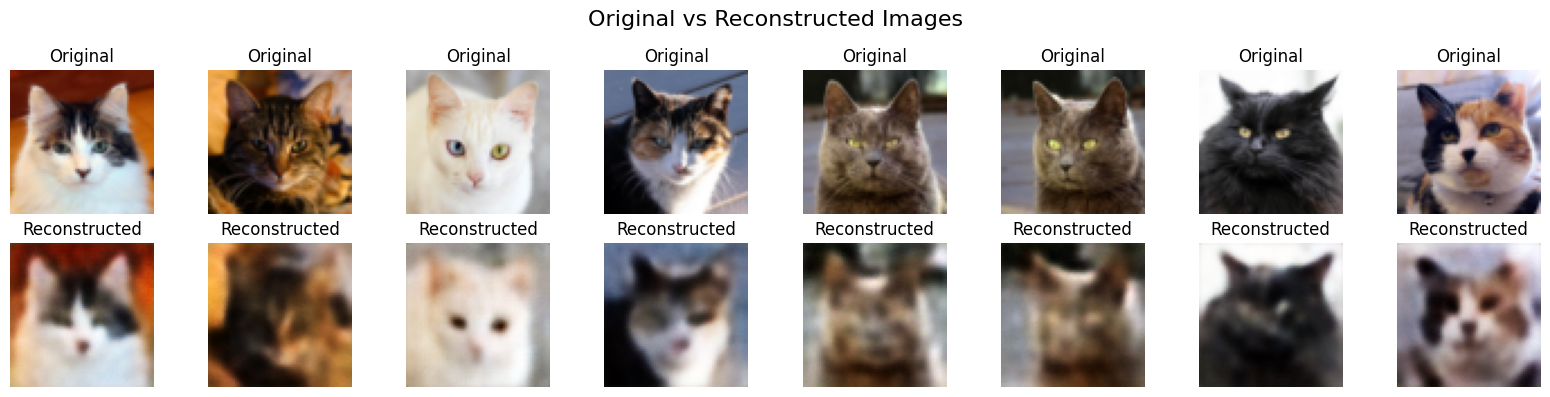

In [67]:
data_iter = iter(val_loader)
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

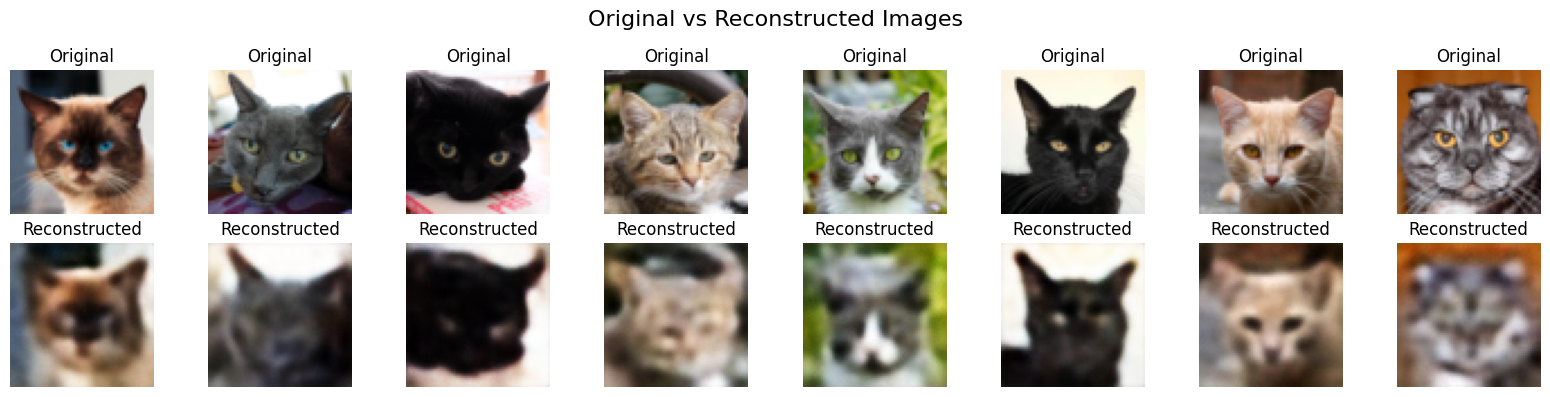

In [68]:
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

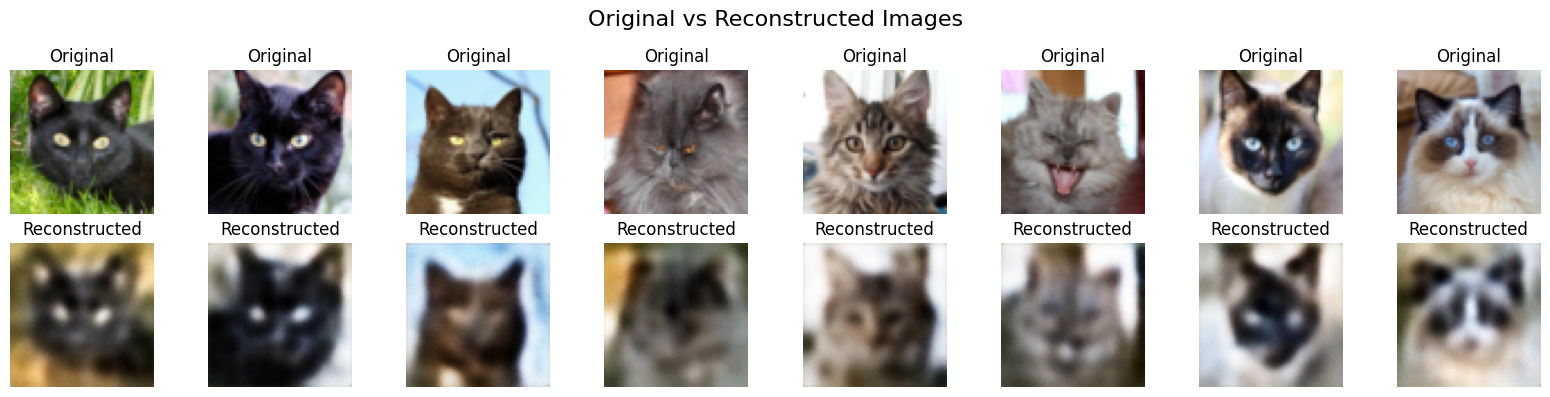

In [60]:
images, _ = next(data_iter)
visualize_reconstructions(model, images, device)

In [97]:
model, train_losses, eval_losses = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.0001
)

  0%|                                                                | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [44]:
def visualize_reconstructions(model, dataloader, device, mean, std, num_images=8):
    """
    Visualizes original and reconstructed images from the VAE.
    
    Args:
        model: Trained VAE model.
        dataloader: DataLoader to sample images from.
        device: Device (CPU or CUDA) to perform inference.
        mean: Mean used for normalization during dataset preprocessing.
        std: Standard deviation used for normalization during dataset preprocessing.
        num_images: Number of images to visualize.
    """
    model.eval()

    # Move mean and std to the same device as images
    mean = mean.to(device)
    std = std.to(device)

    # Randomly sample a batch of images from the dataloader
    data_iter = iter(dataloader)
    images = next(data_iter)  # Assuming the dataloader returns images and labels
    images = images.to(device)

    # If you need only `num_images` samples
    images = images[:num_images]

    with torch.no_grad():
        recon_images, _, _ = model(images)  # Pass images through the VAE

    # Denormalize the images
    images = images * std[None, :, None, None] + mean[None, :, None, None]
    recon_images = recon_images * std[None, :, None, None] + mean[None, :, None, None]

    # Convert tensors to CPU for visualization
    images = images.cpu().numpy()
    recon_images = recon_images.cpu().numpy()

    # Plot original and reconstructed images
    plt.figure(figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Original")

        # Reconstructed images
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon_images[i].transpose(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
        plt.axis("off")
        plt.title("Reconstructed")

    plt.suptitle("Original vs Reconstructed Images", fontsize=16)
    plt.show()

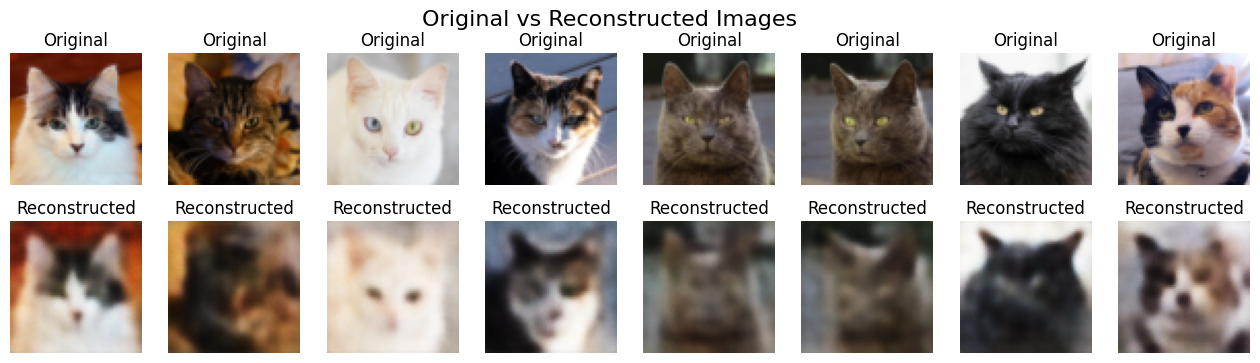

In [45]:
# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)

In [46]:
model, train_losses, eval_losses = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=20, learning_rate=0.0001
)

  5%|██▊                                                     | 1/20 [00:09<02:57,  9.32s/it]

Epoch 1/20
Train Loss: 420.1857
Eval Loss: 372.5848


 10%|█████▌                                                  | 2/20 [00:18<02:50,  9.46s/it]

Epoch 2/20
Train Loss: 399.5285
Eval Loss: 378.7078


 15%|████████▍                                               | 3/20 [00:27<02:37,  9.25s/it]

Epoch 3/20
Train Loss: 391.9487
Eval Loss: 360.3345


 20%|███████████▏                                            | 4/20 [00:37<02:29,  9.37s/it]

Epoch 4/20
Train Loss: 385.6536
Eval Loss: 365.3506


 25%|██████████████                                          | 5/20 [00:47<02:21,  9.45s/it]

Epoch 5/20
Train Loss: 374.0900
Eval Loss: 351.6561


 30%|████████████████▊                                       | 6/20 [00:56<02:12,  9.48s/it]

Epoch 6/20
Train Loss: 369.4432
Eval Loss: 340.1755


 35%|███████████████████▌                                    | 7/20 [01:05<02:01,  9.37s/it]

Epoch 7/20
Train Loss: 360.3737
Eval Loss: 341.9932


 40%|██████████████████████▍                                 | 8/20 [01:15<01:53,  9.42s/it]

Epoch 8/20
Train Loss: 353.8479
Eval Loss: 328.4788


 45%|█████████████████████████▏                              | 9/20 [01:24<01:42,  9.32s/it]

Epoch 9/20
Train Loss: 349.6205
Eval Loss: 325.5433


 50%|███████████████████████████▌                           | 10/20 [01:33<01:33,  9.34s/it]

Epoch 10/20
Train Loss: 343.4281
Eval Loss: 324.4973


 55%|██████████████████████████████▎                        | 11/20 [01:42<01:23,  9.28s/it]

Epoch 11/20
Train Loss: 337.7159
Eval Loss: 333.7383


 60%|█████████████████████████████████                      | 12/20 [01:51<01:13,  9.23s/it]

Epoch 12/20
Train Loss: 332.8294
Eval Loss: 316.4426


 65%|███████████████████████████████████▊                   | 13/20 [02:01<01:05,  9.30s/it]

Epoch 13/20
Train Loss: 328.6202
Eval Loss: 318.3189


 70%|██████████████████████████████████████▌                | 14/20 [02:10<00:56,  9.36s/it]

Epoch 14/20
Train Loss: 326.5282
Eval Loss: 310.0342


 75%|█████████████████████████████████████████▎             | 15/20 [02:20<00:47,  9.52s/it]

Epoch 15/20
Train Loss: 318.3418
Eval Loss: 317.7981


 80%|████████████████████████████████████████████           | 16/20 [02:30<00:38,  9.54s/it]

Epoch 16/20
Train Loss: 316.3282
Eval Loss: 309.0268


 85%|██████████████████████████████████████████████▊        | 17/20 [02:39<00:28,  9.43s/it]

Epoch 17/20
Train Loss: 311.1346
Eval Loss: 304.5091


 90%|█████████████████████████████████████████████████▌     | 18/20 [02:48<00:18,  9.34s/it]

Epoch 18/20
Train Loss: 307.5071
Eval Loss: 303.9959


 95%|████████████████████████████████████████████████████▎  | 19/20 [02:58<00:09,  9.36s/it]

Epoch 19/20
Train Loss: 302.9395
Eval Loss: 301.5095


100%|███████████████████████████████████████████████████████| 20/20 [03:07<00:00,  9.36s/it]

Epoch 20/20
Train Loss: 301.8189
Eval Loss: 306.4068


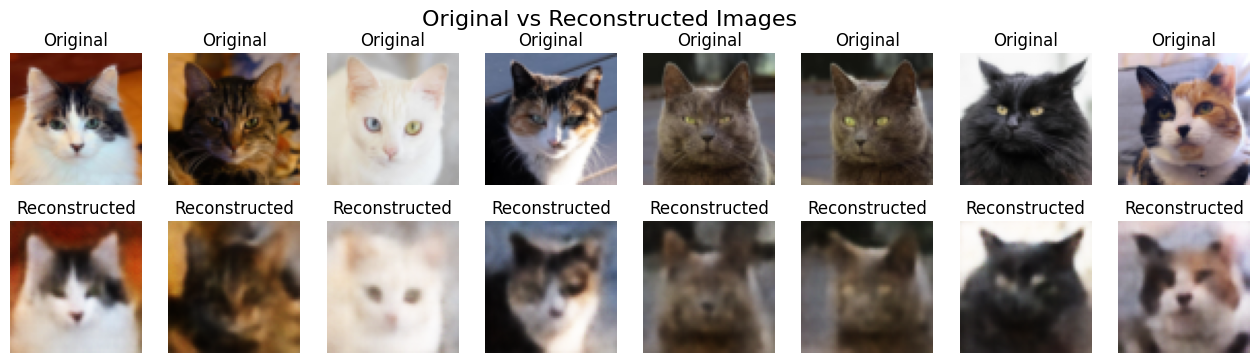

In [47]:
# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)

In [49]:
model, train_losses, eval_losses = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=30, learning_rate=0.0001, name='run1'
)

  3%|█▊                                                      | 1/30 [00:09<04:27,  9.23s/it]

Epoch 1/30
Train Loss: 300.2730
Eval Loss: 303.1140


  7%|███▋                                                    | 2/30 [00:18<04:23,  9.40s/it]

Epoch 2/30
Train Loss: 296.2067
Eval Loss: 300.0240


 10%|█████▌                                                  | 3/30 [00:28<04:15,  9.46s/it]

Epoch 3/30
Train Loss: 291.3279
Eval Loss: 300.1369


 13%|███████▍                                                | 4/30 [00:37<04:07,  9.50s/it]

Epoch 4/30
Train Loss: 288.6725
Eval Loss: 298.9801


 17%|█████████▎                                              | 5/30 [00:47<03:58,  9.53s/it]

Epoch 5/30
Train Loss: 286.3621
Eval Loss: 294.9162


 20%|███████████▏                                            | 6/30 [00:56<03:48,  9.53s/it]

Epoch 6/30
Train Loss: 281.6007
Eval Loss: 295.7013


 23%|█████████████                                           | 7/30 [01:06<03:39,  9.55s/it]

Epoch 7/30
Train Loss: 280.6891
Eval Loss: 296.9227


 27%|██████████████▉                                         | 8/30 [01:16<03:30,  9.55s/it]

Epoch 8/30
Train Loss: 274.9816
Eval Loss: 295.2517


 30%|████████████████▊                                       | 9/30 [01:25<03:20,  9.55s/it]

Epoch 9/30
Train Loss: 274.3158
Eval Loss: 293.9714


 33%|██████████████████▎                                    | 10/30 [01:35<03:10,  9.53s/it]

Epoch 10/30
Train Loss: 270.7099
Eval Loss: 294.8699


 37%|████████████████████▏                                  | 11/30 [01:44<03:01,  9.55s/it]

Epoch 11/30
Train Loss: 269.5411
Eval Loss: 297.0221


 40%|██████████████████████                                 | 12/30 [01:54<02:51,  9.55s/it]

Epoch 12/30
Train Loss: 266.0764
Eval Loss: 290.8260


 43%|███████████████████████▊                               | 13/30 [02:03<02:42,  9.54s/it]

Epoch 13/30
Train Loss: 264.1281
Eval Loss: 293.8115


 47%|█████████████████████████▋                             | 14/30 [02:13<02:32,  9.52s/it]

Epoch 14/30
Train Loss: 260.5627
Eval Loss: 291.5439


 50%|███████████████████████████▌                           | 15/30 [02:22<02:23,  9.54s/it]

Epoch 15/30
Train Loss: 258.1525
Eval Loss: 291.2534


 53%|█████████████████████████████▎                         | 16/30 [02:32<02:13,  9.52s/it]

Epoch 16/30
Train Loss: 256.1684
Eval Loss: 292.0461


 57%|███████████████████████████████▏                       | 17/30 [02:41<02:04,  9.54s/it]

Epoch 17/30
Train Loss: 255.3361
Eval Loss: 288.8895


 60%|█████████████████████████████████                      | 18/30 [02:51<01:54,  9.55s/it]

Epoch 18/30
Train Loss: 251.8852
Eval Loss: 289.0588


 63%|██████████████████████████████████▊                    | 19/30 [03:00<01:44,  9.53s/it]

Epoch 19/30
Train Loss: 251.5093
Eval Loss: 294.6378


 67%|████████████████████████████████████▋                  | 20/30 [03:10<01:35,  9.54s/it]

Epoch 20/30
Train Loss: 249.4826
Eval Loss: 287.1467


 70%|██████████████████████████████████████▌                | 21/30 [03:20<01:26,  9.58s/it]

Epoch 21/30
Train Loss: 246.8831
Eval Loss: 289.0973


 73%|████████████████████████████████████████▎              | 22/30 [03:29<01:16,  9.61s/it]

Epoch 22/30
Train Loss: 247.0297
Eval Loss: 290.4271


 77%|██████████████████████████████████████████▏            | 23/30 [03:39<01:07,  9.58s/it]

Epoch 23/30
Train Loss: 243.8651
Eval Loss: 291.2767


 80%|████████████████████████████████████████████           | 24/30 [03:48<00:57,  9.58s/it]

Epoch 24/30
Train Loss: 242.5301
Eval Loss: 290.8650


 83%|█████████████████████████████████████████████▊         | 25/30 [03:58<00:47,  9.56s/it]

Epoch 25/30
Train Loss: 239.4873
Eval Loss: 292.0124


 87%|███████████████████████████████████████████████▋       | 26/30 [04:08<00:38,  9.54s/it]

Epoch 26/30
Train Loss: 238.6304
Eval Loss: 290.0548


 90%|█████████████████████████████████████████████████▌     | 27/30 [04:17<00:28,  9.55s/it]

Epoch 27/30
Train Loss: 237.5747
Eval Loss: 285.4354


 93%|███████████████████████████████████████████████████▎   | 28/30 [04:27<00:19,  9.56s/it]

Epoch 28/30
Train Loss: 235.7624
Eval Loss: 288.2370


 97%|█████████████████████████████████████████████████████▏ | 29/30 [04:36<00:09,  9.54s/it]

Epoch 29/30
Train Loss: 234.1267
Eval Loss: 292.8428


100%|███████████████████████████████████████████████████████| 30/30 [04:46<00:00,  9.54s/it]

Epoch 30/30
Train Loss: 233.5316
Eval Loss: 289.5791


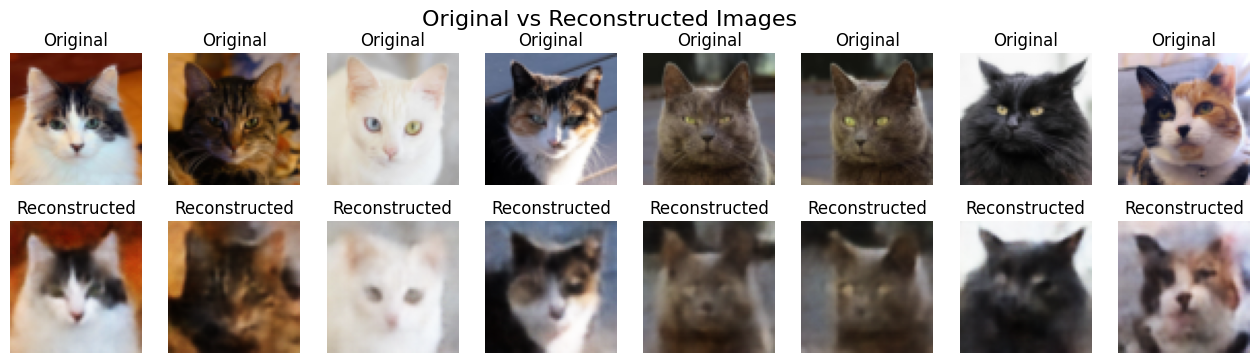

In [50]:
# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)

  4%|██▏                                                     | 1/25 [00:09<03:47,  9.46s/it]

Epoch 1/25
Train Loss: 1251.7123
Eval Loss: 739.6957


  8%|████▍                                                   | 2/25 [00:18<03:38,  9.48s/it]

Epoch 2/25
Train Loss: 682.3177
Eval Loss: 575.8401


 12%|██████▋                                                 | 3/25 [00:28<03:28,  9.46s/it]

Epoch 3/25
Train Loss: 586.9776
Eval Loss: 538.8554


 16%|████████▉                                               | 4/25 [00:37<03:18,  9.43s/it]

Epoch 4/25
Train Loss: 539.8739
Eval Loss: 495.3609


 20%|███████████▏                                            | 5/25 [00:46<03:06,  9.33s/it]

Epoch 5/25
Train Loss: 508.3522
Eval Loss: 464.4874


 24%|█████████████▍                                          | 6/25 [00:56<02:55,  9.26s/it]

Epoch 6/25
Train Loss: 484.1644
Eval Loss: 431.6545


 28%|███████████████▋                                        | 7/25 [01:05<02:48,  9.37s/it]

Epoch 7/25
Train Loss: 467.0350
Eval Loss: 421.7675


 32%|█████████████████▉                                      | 8/25 [01:15<02:39,  9.41s/it]

Epoch 8/25
Train Loss: 452.4670
Eval Loss: 418.6872


 36%|████████████████████▏                                   | 9/25 [01:24<02:31,  9.45s/it]

Epoch 9/25
Train Loss: 435.1197
Eval Loss: 411.8853


 40%|██████████████████████                                 | 10/25 [01:34<02:21,  9.46s/it]

Epoch 10/25
Train Loss: 420.9045
Eval Loss: 394.0731


 44%|████████████████████████▏                              | 11/25 [01:43<02:12,  9.45s/it]

Epoch 11/25
Train Loss: 406.5021
Eval Loss: 386.4238


 48%|██████████████████████████▍                            | 12/25 [01:53<02:03,  9.46s/it]

Epoch 12/25
Train Loss: 397.0333
Eval Loss: 361.0973


 52%|████████████████████████████▌                          | 13/25 [02:02<01:53,  9.45s/it]

Epoch 13/25
Train Loss: 389.1747
Eval Loss: 358.3000


 56%|██████████████████████████████▊                        | 14/25 [02:11<01:42,  9.35s/it]

Epoch 14/25
Train Loss: 380.7868
Eval Loss: 352.6691


 60%|█████████████████████████████████                      | 15/25 [02:20<01:32,  9.26s/it]

Epoch 15/25
Train Loss: 372.5869
Eval Loss: 344.4352


 64%|███████████████████████████████████▏                   | 16/25 [02:29<01:23,  9.27s/it]

Epoch 16/25
Train Loss: 364.8031
Eval Loss: 337.0154


 68%|█████████████████████████████████████▍                 | 17/25 [02:39<01:13,  9.22s/it]

Epoch 17/25
Train Loss: 358.8223
Eval Loss: 336.2761


 72%|███████████████████████████████████████▌               | 18/25 [02:48<01:04,  9.22s/it]

Epoch 18/25
Train Loss: 355.5880
Eval Loss: 334.7729


 76%|█████████████████████████████████████████▊             | 19/25 [02:57<00:55,  9.24s/it]

Epoch 19/25
Train Loss: 349.8932
Eval Loss: 331.1632


 80%|████████████████████████████████████████████           | 20/25 [03:07<00:46,  9.33s/it]

Epoch 20/25
Train Loss: 344.6419
Eval Loss: 333.9443


 84%|██████████████████████████████████████████████▏        | 21/25 [03:16<00:37,  9.37s/it]

Epoch 21/25
Train Loss: 340.5793
Eval Loss: 323.2902


 88%|████████████████████████████████████████████████▍      | 22/25 [03:26<00:28,  9.39s/it]

Epoch 22/25
Train Loss: 333.8304
Eval Loss: 318.5866


 92%|██████████████████████████████████████████████████▌    | 23/25 [03:35<00:18,  9.43s/it]

Epoch 23/25
Train Loss: 328.4436
Eval Loss: 319.3697


 96%|████████████████████████████████████████████████████▊  | 24/25 [03:45<00:09,  9.46s/it]

Epoch 24/25
Train Loss: 324.2448
Eval Loss: 328.2996


100%|███████████████████████████████████████████████████████| 25/25 [03:54<00:00,  9.37s/it]

Epoch 25/25
Train Loss: 321.9323
Eval Loss: 309.7926


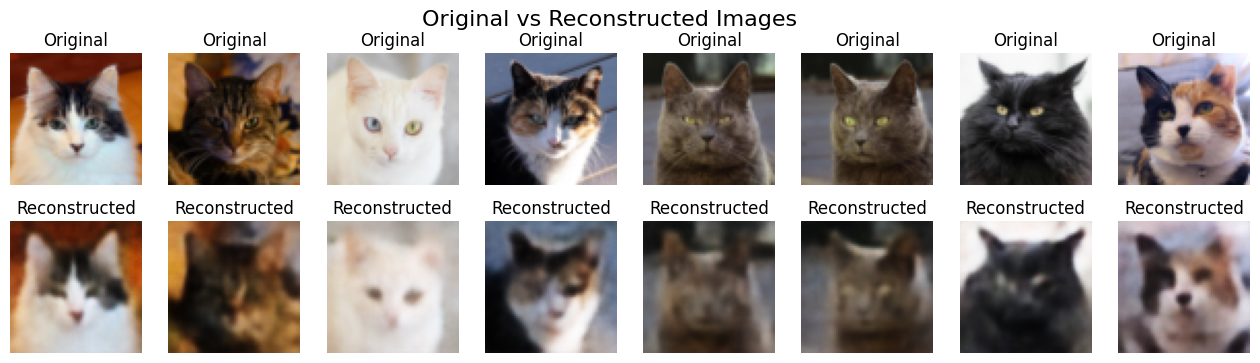

In [60]:
model, train_losses, eval_losses = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=25, learning_rate=0.0001, name='run1', kl_weight=0.1
)

# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)

  4%|██▏                                                     | 1/25 [00:09<03:48,  9.51s/it]

Epoch 1/25
Train Loss: 1368.6309
Eval Loss: 991.8209


  8%|████▍                                                   | 2/25 [00:18<03:36,  9.41s/it]

Epoch 2/25
Train Loss: 918.7374
Eval Loss: 775.9441


 12%|██████▋                                                 | 3/25 [00:28<03:24,  9.31s/it]

Epoch 3/25
Train Loss: 806.4440
Eval Loss: 750.3469


 16%|████████▉                                               | 4/25 [00:37<03:16,  9.35s/it]

Epoch 4/25
Train Loss: 760.8106
Eval Loss: 662.5677


 20%|███████████▏                                            | 5/25 [00:46<03:07,  9.36s/it]

Epoch 5/25
Train Loss: 725.5130
Eval Loss: 633.4300


 24%|█████████████▍                                          | 6/25 [00:56<02:57,  9.35s/it]

Epoch 6/25
Train Loss: 700.3410
Eval Loss: 643.7927


 28%|███████████████▋                                        | 7/25 [01:05<02:47,  9.28s/it]

Epoch 7/25
Train Loss: 676.6827
Eval Loss: 589.2352


 32%|█████████████████▉                                      | 8/25 [01:14<02:37,  9.24s/it]

Epoch 8/25
Train Loss: 659.2089
Eval Loss: 571.1504


 36%|████████████████████▏                                   | 9/25 [01:23<02:27,  9.25s/it]

Epoch 9/25
Train Loss: 642.7279
Eval Loss: 591.0638


 40%|██████████████████████                                 | 10/25 [01:33<02:18,  9.26s/it]

Epoch 10/25
Train Loss: 627.1635
Eval Loss: 561.0483


 44%|████████████████████████▏                              | 11/25 [01:42<02:10,  9.31s/it]

Epoch 11/25
Train Loss: 611.0961
Eval Loss: 536.3398


 48%|██████████████████████████▍                            | 12/25 [01:51<02:01,  9.32s/it]

Epoch 12/25
Train Loss: 595.1077
Eval Loss: 534.3325


 52%|████████████████████████████▌                          | 13/25 [02:01<01:51,  9.30s/it]

Epoch 13/25
Train Loss: 587.8570
Eval Loss: 516.9507


 56%|██████████████████████████████▊                        | 14/25 [02:10<01:42,  9.31s/it]

Epoch 14/25
Train Loss: 574.7112
Eval Loss: 507.6282


 60%|█████████████████████████████████                      | 15/25 [02:19<01:32,  9.27s/it]

Epoch 15/25
Train Loss: 568.0307
Eval Loss: 499.1533


 64%|███████████████████████████████████▏                   | 16/25 [02:28<01:23,  9.27s/it]

Epoch 16/25
Train Loss: 558.7965
Eval Loss: 490.3264


 68%|█████████████████████████████████████▍                 | 17/25 [02:38<01:14,  9.30s/it]

Epoch 17/25
Train Loss: 552.1257
Eval Loss: 494.1048


 72%|███████████████████████████████████████▌               | 18/25 [02:47<01:05,  9.31s/it]

Epoch 18/25
Train Loss: 545.0658
Eval Loss: 479.0356


 76%|█████████████████████████████████████████▊             | 19/25 [02:56<00:55,  9.31s/it]

Epoch 19/25
Train Loss: 536.9539
Eval Loss: 472.0483


 80%|████████████████████████████████████████████           | 20/25 [03:06<00:46,  9.32s/it]

Epoch 20/25
Train Loss: 529.3573
Eval Loss: 470.4542


 84%|██████████████████████████████████████████████▏        | 21/25 [03:15<00:37,  9.28s/it]

Epoch 21/25
Train Loss: 526.3075
Eval Loss: 472.3890


 88%|████████████████████████████████████████████████▍      | 22/25 [03:24<00:27,  9.25s/it]

Epoch 22/25
Train Loss: 521.0885
Eval Loss: 470.0428


 92%|██████████████████████████████████████████████████▌    | 23/25 [03:33<00:18,  9.24s/it]

Epoch 23/25
Train Loss: 515.5037
Eval Loss: 472.4437


 96%|████████████████████████████████████████████████████▊  | 24/25 [03:42<00:09,  9.22s/it]

Epoch 24/25
Train Loss: 512.3386
Eval Loss: 464.1310


100%|███████████████████████████████████████████████████████| 25/25 [03:52<00:00,  9.29s/it]

Epoch 25/25
Train Loss: 509.1804
Eval Loss: 455.9744


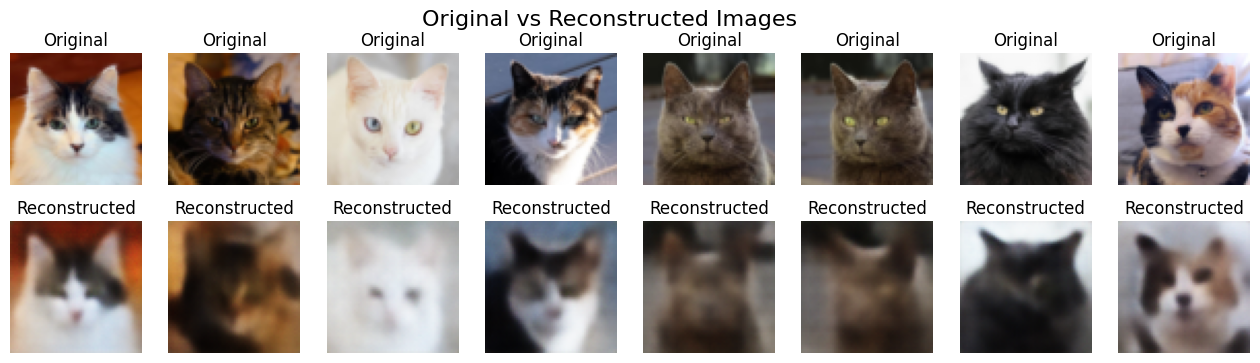

In [62]:
latent_dim = 512
model = EnhancedConvVAE(latent_dim=latent_dim).to(device)

model, train_losses, eval_losses = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=25, learning_rate=0.0001, name='run2', kl_weight=0.5
)

# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)

  4%|██▏                                                     | 1/25 [00:09<03:43,  9.31s/it]

Epoch 1/25
Train Loss: 1465.1797
Eval Loss: 1407.7468


  8%|████▍                                                   | 2/25 [00:18<03:31,  9.21s/it]

Epoch 2/25
Train Loss: 1070.7973
Eval Loss: 931.5602


 12%|██████▋                                                 | 3/25 [00:28<03:26,  9.37s/it]

Epoch 3/25
Train Loss: 949.7414
Eval Loss: 830.5016


 16%|████████▉                                               | 4/25 [00:37<03:14,  9.26s/it]

Epoch 4/25
Train Loss: 894.3799
Eval Loss: 799.6551


 20%|███████████▏                                            | 5/25 [00:46<03:04,  9.24s/it]

Epoch 5/25
Train Loss: 858.2452
Eval Loss: 787.0127


 24%|█████████████▍                                          | 6/25 [00:55<02:53,  9.16s/it]

Epoch 6/25
Train Loss: 825.7084
Eval Loss: 786.6760


 28%|███████████████▋                                        | 7/25 [01:04<02:44,  9.12s/it]

Epoch 7/25
Train Loss: 801.4663
Eval Loss: 741.8707


 32%|█████████████████▉                                      | 8/25 [01:13<02:34,  9.10s/it]

Epoch 8/25
Train Loss: 777.7446
Eval Loss: 707.9427


 36%|████████████████████▏                                   | 9/25 [01:22<02:25,  9.12s/it]

Epoch 9/25
Train Loss: 763.7223
Eval Loss: 689.5918


 40%|██████████████████████                                 | 10/25 [01:31<02:16,  9.12s/it]

Epoch 10/25
Train Loss: 746.6568
Eval Loss: 665.4645


 44%|████████████████████████▏                              | 11/25 [01:41<02:08,  9.19s/it]

Epoch 11/25
Train Loss: 731.8673
Eval Loss: 660.7614


 48%|██████████████████████████▍                            | 12/25 [01:50<02:00,  9.26s/it]

Epoch 12/25
Train Loss: 721.3478
Eval Loss: 661.0616


 52%|████████████████████████████▌                          | 13/25 [01:59<01:51,  9.30s/it]

Epoch 13/25
Train Loss: 704.7092
Eval Loss: 646.0093


 56%|██████████████████████████████▊                        | 14/25 [02:08<01:41,  9.25s/it]

Epoch 14/25
Train Loss: 691.8679
Eval Loss: 646.4899


 60%|█████████████████████████████████                      | 15/25 [02:18<01:32,  9.29s/it]

Epoch 15/25
Train Loss: 680.7966
Eval Loss: 638.2701


 64%|███████████████████████████████████▏                   | 16/25 [02:27<01:24,  9.34s/it]

Epoch 16/25
Train Loss: 672.2586
Eval Loss: 615.8287


 68%|█████████████████████████████████████▍                 | 17/25 [02:37<01:16,  9.50s/it]

Epoch 17/25
Train Loss: 664.5622
Eval Loss: 597.5797


 72%|███████████████████████████████████████▌               | 18/25 [02:47<01:07,  9.66s/it]

Epoch 18/25
Train Loss: 659.7908
Eval Loss: 613.3923


 76%|█████████████████████████████████████████▊             | 19/25 [02:57<00:57,  9.62s/it]

Epoch 19/25
Train Loss: 650.4927
Eval Loss: 583.1046


 80%|████████████████████████████████████████████           | 20/25 [03:06<00:47,  9.47s/it]

Epoch 20/25
Train Loss: 643.8870
Eval Loss: 576.7328


 84%|██████████████████████████████████████████████▏        | 21/25 [03:15<00:37,  9.36s/it]

Epoch 21/25
Train Loss: 639.8167
Eval Loss: 571.9169


 88%|████████████████████████████████████████████████▍      | 22/25 [03:24<00:27,  9.25s/it]

Epoch 22/25
Train Loss: 639.8501
Eval Loss: 568.7393


 92%|██████████████████████████████████████████████████▌    | 23/25 [03:33<00:18,  9.21s/it]

Epoch 23/25
Train Loss: 632.2304
Eval Loss: 582.1539


 96%|████████████████████████████████████████████████████▊  | 24/25 [03:42<00:09,  9.16s/it]

Epoch 24/25
Train Loss: 626.7668
Eval Loss: 570.1084


100%|███████████████████████████████████████████████████████| 25/25 [03:51<00:00,  9.27s/it]

Epoch 25/25
Train Loss: 622.6161
Eval Loss: 586.0340


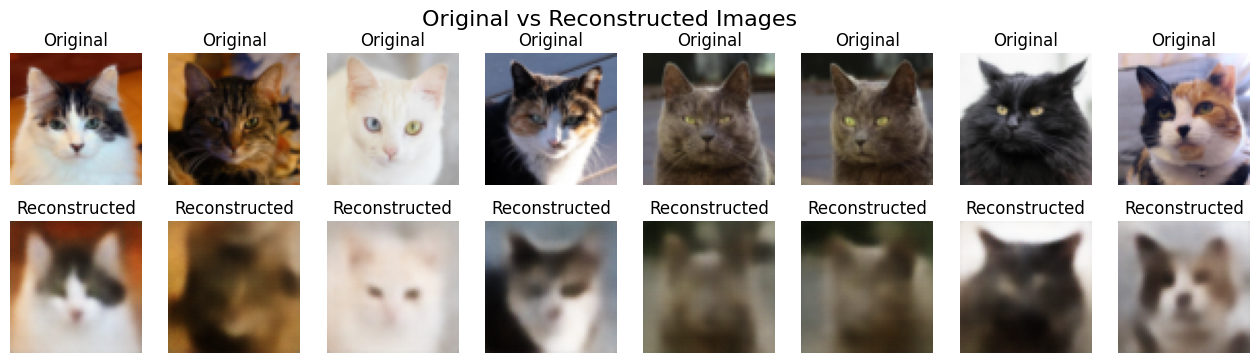

In [63]:
latent_dim = 512
model = EnhancedConvVAE(latent_dim=latent_dim).to(device)

model, train_losses, eval_losses = run_vae_training(
    model, train_loader, val_loader, device, num_epochs=25, learning_rate=0.0001, name='run3', kl_weight=1.0
)

# Assuming images were normalized with mean and std (for example, for CIFAR-10)
mean = torch.tensor([0.5, 0.5, 0.5])  # Example mean for RGB images
std = torch.tensor([0.5, 0.5, 0.5])   # Example std for RGB images

# Visualize the images
visualize_reconstructions(model, val_loader, device, mean, std)